In [18]:

#!pip install fast_ml 


Pobieranie paczek

In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_duplicate_features
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed = 42
from sklearn import preprocessing
from fast_ml.feature_selection import get_constant_features
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


Pobranie zbioru z danymi

In [7]:
df1 = pd.read_csv('dataset_1.csv')
print("Rozmiar ramki: ", df1.shape)

Rozmiar ramki:  (50000, 301)


Sprawdźmy czy w ramce są wartości Null

In [6]:
df1.isnull().sum().sum()

0

W ramce nie mamy żadnych wartości Null

In [11]:
df1.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

W ramce mamy tylko wartości typu int oraz float

Oddzielenie zmiennej przewidywanej 'target'

In [4]:
y = np.array(df1['target'])
X = df1.drop(['target'],axis=1)

Sprawdźmy rozkład przewidywanej zmiennej 'target'

In [12]:
unique, counts = np.unique(y, return_counts=True)
print("Rozkład w całej ramce: ", dict(zip(unique, counts)))

Rozkład w całej ramce:  {0: 48009, 1: 1991}


Rozkład jest bardzo nie równy zatem przy dzieleniu na zbiory test, train i val użyjemy stratify

Podział na zbiory test, train i val

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
)

In [5]:
X_train.shape

(35000, 300)

Tworzymy ramke, która jest kopią X_train, na której będziemy wykonywać różne procedury processingu danych.

In [6]:
X_train_processing = X_train.copy()

Zaczniemy od usunięcia kolumn ze stałymi wartościami

In [7]:
constant_features = get_constant_features(X_train_processing)

In [8]:
constant_features_list = constant_features.query("Desc=='Constant'")['Var'].to_list()
print(constant_features_list)

['var_167', 'var_158', 'var_113', 'var_112', 'var_201', 'var_248', 'var_44', 'var_99', 'var_97', 'var_212', 'var_215', 'var_92', 'var_89', 'var_61', 'var_227', 'var_87', 'var_66', 'var_67', 'var_225', 'var_69', 'var_81', 'var_196', 'var_33', 'var_195', 'var_287', 'var_297', 'var_294', 'var_171', 'var_178', 'var_180', 'var_135', 'var_182', 'var_120', 'var_14', 'var_23', 'var_129', 'var_127', 'var_122', 'var_80']


In [9]:
print('Rozmiar ramki przed usunięciem stałych kolumn: ', X_train_processing.shape)
X_train_processing.drop(columns = constant_features_list, inplace=True)
print('Rozmiar ramki po usunięciu stałych kolumn: ', X_train_processing.shape)

Rozmiar ramki przed usunięciem stałych kolumn:  (35000, 300)
Rozmiar ramki po usunięciu stałych kolumn:  (35000, 261)


In [10]:
def drop_constant_features(df):
  constant_features = get_constant_features(df)
  constant_features_list = constant_features.query("Desc=='Constant'")['Var'].to_list()
  df.drop(columns = constant_features_list, inplace=True)
  return df

Zajmiemy się też usunięciem "prawie stałych" kolumn, ustawiony threshold jest na tyle wysoki, że usuwamy jedynie kolumny które mają dosłownie kilka odmiennych wartości. Małe ryzyko utraty informacji

In [11]:
constant_features = get_constant_features(X_train_processing, threshold=0.9999, dropna=False)

In [12]:
quasi_constant_features_list = constant_features.query("Desc=='Quasi Constant'")['Var'].to_list()
print(quasi_constant_features_list)

['var_2', 'var_36', 'var_133', 'var_124', 'var_104', 'var_73', 'var_223', 'var_170', 'var_183', 'var_34', 'var_234', 'var_243', 'var_247', 'var_280', 'var_283', 'var_233', 'var_217', 'var_210', 'var_285', 'var_189', 'var_187', 'var_228', 'var_150', 'var_153', 'var_151', 'var_10', 'var_11', 'var_12', 'var_28', 'var_65', 'var_72', 'var_111', 'var_141', 'var_6', 'var_71', 'var_116', 'var_265', 'var_9', 'var_7', 'var_289']


Jak widać jest ich całkiem sporo

In [13]:
print('Rozmiar ramki przed usunięciem "prawie stałych" kolumn:  ', X_train_processing.shape)
X_train_processing.drop(columns = quasi_constant_features_list, inplace=True)
print('Rozmiar ramki po usunięciu "prawie stałych" kolumn: ', X_train_processing.shape)

Rozmiar ramki przed usunięciem "prawie stałych" kolumn:   (35000, 261)
Rozmiar ramki po usunięciu "prawie stałych" kolumn:  (35000, 221)


In [14]:
def drop_quasi_constant_features(df):
  quasi_constant_features = get_constant_features(X_train, threshold=0.9999, dropna=False)
  quasi_constant_features_list = quasi_constant_features.query("Desc=='Quasi Constant'")['Var'].to_list()
  df.drop(columns = quasi_constant_features_list, inplace=True)
  return df

Usunięcie zduplikowanych kolumn

In [15]:
duplicate_features = get_duplicate_features(X_train_processing)

In [16]:
duplicate_features_list = duplicate_features.query("Desc=='Duplicate Values'")['feature2'].to_list()
print(duplicate_features_list)

['var_239', 'var_148', 'var_269', 'var_232', 'var_106', 'var_216', 'var_263', 'var_250', 'var_199', 'var_296']


In [17]:
print('Rozmiar ramki przed usunięciem zduplikowanych kolumn:  ', X_train_processing.shape)
X_train_processing.drop(columns = duplicate_features_list, inplace = True)
print('Rozmiar ramki po usunięciu zduplikowanych kolumn: ', X_train_processing.shape)


Rozmiar ramki przed usunięciem zduplikowanych kolumn:   (35000, 221)
Rozmiar ramki po usunięciu zduplikowanych kolumn:  (35000, 211)


In [18]:
def drop_duplicates(df):
  duplicate_features = get_duplicate_features(df)
  duplicate_features_list = duplicate_features.query("Desc=='Duplicate Values'")['feature2'].to_list()
  df.drop(columns = duplicate_features_list, inplace = True)
  return df

Outliery

In [19]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
print(((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).sum())
print("W sumie wszystkich outlierów jest: ", ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).sum().sum())

var_1        16
var_2         1
var_3        16
var_4      2863
var_5       193
           ... 
var_296     841
var_297       0
var_298      63
var_299      25
var_300    1341
Length: 300, dtype: int64
W sumie wszystkich outlierów jest:  326676


Spróbujemy dobrać inne granice klasyfikacji outlierów i zobaczyć czy nadal jest ich tak dużo. Zmieńmy współczynnik przy IQR nas 2.5

In [38]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
print(((X_train < (Q1 - 2.5 * IQR)) | (X_train > (Q3 + 2.5 * IQR))).sum())
print("W sumie wszystkich outlierów jest: ", ((X_train < (Q1 - 2.5 * IQR)) | (X_train > (Q3 + 2.5 * IQR))).sum().sum())

var_1        16
var_2         1
var_3        16
var_4       775
var_5       193
           ... 
var_296     841
var_297       0
var_298      63
var_299      25
var_300    1341
Length: 300, dtype: int64
W sumie wszystkich outlierów jest:  309035


Nadal outlierów jest bardzo dużo, dlatego usuwanie nie wchodzi w grę. Zatem zaminimy dolny oraz górny centyl wartości medianą

In [20]:
def replace_numerical_outliers(df, z_thresh=3):
    for col in df:
        median = df[col].median()
        outliers = (df[col] > df[col].quantile(.99)) | (df[col] < df[col].quantile(.01))
        df[col][outliers]=np.nan
        df.replace({np.nan:median}, inplace=True)
    return df

In [21]:
X_train_processing = replace_numerical_outliers(X_train_processing)
X_train_processing

,var_1,var_3,var_4,var_5,var_8,var_13,var_15,var_16,var_17,var_18,...,var_286,var_288,var_290,var_291,var_292,var_293,var_295,var_298,var_299,var_300
13889,0.0,0.0,2.88,0.0,0,0.0,3.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
18173,0.0,0.0,2.91,0.0,0,0.0,3.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
11779,0.0,0.0,2.82,0.0,0,0.0,3.0,0.0,14.25,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
28068,0.0,0.0,5.82,0.0,0,0.0,3.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
26232,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28062,0.0,0.0,11.04,0.0,0,0.0,0.0,0.0,5.82,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
44991,0.0,0.0,5.70,0.0,0,0.0,3.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
42528,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,5.82,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
31683,0.0,0.0,8.73,0.0,0,0.0,3.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,891.36


Po zamianie na medianę powstało dużo nowych kolumn, które mają same zera. Jeszcze raz zatem usuniemy stałe kolumny.

In [22]:
print('Rozmiar ramki przed usunięciem stałych kolumn: ', X_train_processing.shape)
X_train_processing = drop_constant_features(X_train_processing)
print('Rozmiar ramki po usunięciu stałych kolumn: ', X_train_processing.shape)

Rozmiar ramki przed usunięciem stałych kolumn:  (35000, 211)
Rozmiar ramki po usunięciu stałych kolumn:  (35000, 121)


Przejdziemy teraz do metod dalszego usuwania kolumn

Usuwanie (jednej z) kolumn, których współczynnik korelacji spearmana jest większy niż 0.9

In [23]:
def correlation_drop(df):
  corr_matrix = df.corr('spearman')

  n = df.shape[1]
  threshold = 0.90
  var_to_drop = []
  for j in range(n):
    for i in range(j):
      if corr_matrix.iloc[i][j] >= threshold:
        var_to_drop.append(corr_matrix.index[i])
  
  var_to_drop = set(var_to_drop)
  var_to_drop = list(var_to_drop)
  print("liczba kolumn które usuwamy:" ,len(var_to_drop))
  print("lista kolumn, które usuwamy:", var_to_drop)

  df = df.drop(var_to_drop, axis = 1)
  return df

In [24]:
X_train_processing = correlation_drop(X_train_processing)
X_train_processing.describe()

liczba kolumn które usuwamy: 53
lista kolumn, które usuwamy: ['var_18', 'var_140', 'var_31', 'var_47', 'var_82', 'var_38', 'var_8', 'var_21', 'var_105', 'var_96', 'var_37', 'var_186', 'var_144', 'var_70', 'var_109', 'var_118', 'var_62', 'var_100', 'var_152', 'var_57', 'var_30', 'var_226', 'var_284', 'var_103', 'var_51', 'var_41', 'var_4', 'var_155', 'var_123', 'var_168', 'var_131', 'var_93', 'var_175', 'var_220', 'var_55', 'var_206', 'var_83', 'var_117', 'var_121', 'var_88', 'var_143', 'var_229', 'var_176', 'var_166', 'var_58', 'var_162', 'var_91', 'var_174', 'var_164', 'var_52', 'var_19', 'var_203', 'var_160']


,var_15,var_17,var_29,var_35,var_46,var_49,var_50,var_54,var_64,var_74,...,var_272,var_275,var_276,var_277,var_279,var_281,var_288,var_292,var_295,var_300
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,...,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,1.993971,0.961346,1.955717,8995.286265,104663.119482,40.164371,3.067719,0.010429,1713.967004,1.590886,...,0.792747,0.024971,82.269169,1.432810,2.014221,0.011086,0.035178,0.008306,0.127714,2046.161966
std,1.416351,2.467787,0.510095,35907.614867,56806.301485,47.282043,6.771094,0.101588,11541.361699,0.711526,...,3.003194,0.156040,522.019328,5.234437,6.866269,0.104705,0.314429,0.152159,0.605675,15078.432648
min,0.000000,0.000000,1.820000,0.000000,24784.964400,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.860000,0.000000,66240.978300,2.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,1.920000,3.000000,101680.519800,3.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,1.960000,159.297900,116137.869226,99.000000,2.880000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,14.850000,10.670000,285773.062500,429816.927000,99.000000,47.520000,1.000000,137496.787200,2.000000,...,25.920000,1.000000,7948.800000,43.200000,53.010000,1.000000,2.970000,2.850000,3.000000,193611.974400


To kończy nasz podstawowy preprocessing

In [25]:
X_train = pd.DataFrame(X_train_processing)
X_test = X_test[X_test.columns.intersection(X_train.columns)]

Jako dodatkową opcję zmniejszenie liczby kolumn użyjemy Recursive Feature Elimination (RFE), która wybiera kolumny są najbardziej znaczące w przewidywaniu zmiennej target

In [26]:
rfc = RandomForestClassifier()
rfe = RFE(estimator=rfc, n_features_to_select = 20)
rfe.fit_transform(X_train_processing, y_train)
selected_features = X_train_processing.columns[rfe.support_]
print(selected_features)

Index(['var_17', 'var_29', 'var_35', 'var_46', 'var_50', 'var_74', 'var_75',
       'var_76', 'var_110', 'var_145', 'var_157', 'var_161', 'var_173',
       'var_185', 'var_190', 'var_207', 'var_222', 'var_231', 'var_262',
       'var_279'],
      dtype='object')


Zapiszemy wyniki w oddzielnych ramkach

In [27]:
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[X_test.columns.intersection(X_train_rfe.columns)]

### Przechodzimy do Modeli

Sprawdźmy jak rozkłada się zmienna target

In [47]:
unique, counts = np.unique(y, return_counts=True)
print("Rozkład w całej ramce: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Rozkład w zbiorze testowym: ", dict(zip(unique, counts)))

Rozkład w całej ramce:  {0: 48009, 1: 1991}
Rozkład w zbiorze testowym:  {0: 4321, 1: 179}


Widzimy, że wartości 1 jest bardzo mało w porównaniu do wartości 0, w zbiorze testowym jest jedynie 179 wartości 1, co będzie prowadziło do problemów z uzyskaniem wysokiej precyzji.
Uważamy, że tak samo dużą, jak nie większą, uwagę powinniśmy przywiązywąć do wyników cross-validacji, gdyż w tym przypadku może być ona bardziej miarodajna 

####  Logistyczna regresja

In [48]:
from sklearn import linear_model
lr_model = linear_model.LogisticRegression()

Base preprocessing

In [49]:
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.95      4500
   macro avg       0.48      0.49      0.49      4500
weighted avg       0.92      0.95      0.94      4500



Preprocessing RFE

In [50]:
lr_model.fit(X_train_rfe, y_train)

y_pred = lr_model.predict(X_test_rfe)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.96      4500
   macro avg       0.48      0.50      0.49      4500
weighted avg       0.92      0.96      0.94      4500



Jak widać regresja logistyczna działa bardzo słabo gdyż przewiduje same 0, dlatego porzucimy szybko ten model i nie będziemy tracić czasu na cross-validacje

#### Decision Trees

In [63]:
clf = DecisionTreeClassifier(random_state=0)

Base Preprocessing

In [66]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_probs = clf.predict_proba(X_test)[:, 1]

#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))


print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4321
           1       0.13      0.22      0.16       179

    accuracy                           0.91      4500
   macro avg       0.55      0.58      0.56      4500
weighted avg       0.93      0.91      0.92      4500

Wynik ROC-AUC na zbiorze testowym:  0.5782743493837423
Wynik ROC-AUC przez cross-validation:  0.5509427913040436
Wynik F1 przez cross-validation:  0.13228550143053952


Preprocessing RFE

In [67]:
clf.fit(X_train_rfe, y_train)

y_pred = clf.predict(X_test_rfe)
y_pred_probs = clf.predict_proba(X_test_rfe)[:, 1]

#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))


print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      4321
           1       0.12      0.19      0.15       179

    accuracy                           0.91      4500
   macro avg       0.54      0.57      0.55      4500
weighted avg       0.93      0.91      0.92      4500

Wynik ROC-AUC na zbiorze testowym:  0.5670850038592866
Wynik ROC-AUC przez cross-validation:  0.554548303627131
Wynik F1 przez cross-validation:  0.13845906663508853


Uzyskaliśmy lepsze wyniki niż w regresji logistycznej, gdyż mamy precyzję jedynek w okolicy 0.12 oraz wynik F1 jest wysoki w porównaniu do innych modeli jednak wynik ROC-AUC jest słaby zarówno na zbiorze testowym jaki przy cross-validacji. Preprocessing RFE miał marginalny wpływ na wyniki.

#### XGBoost

In [68]:
clf = XGBClassifier(random_state = 0)

Base preprocessing

In [71]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_probs = clf.predict_proba(X_test)[:, 1]

#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))


print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.17      0.01      0.02       179

    accuracy                           0.96      4500
   macro avg       0.56      0.50      0.50      4500
weighted avg       0.93      0.96      0.94      4500

Wynik ROC-AUC na zbiorze testowym:  0.8297007339755567
Wynik ROC-AUC przez cross-validation:  0.7965584976780726
Wynik F1 przez cross-validation:  0.01383803101492854


Preprocessing RFE

In [72]:
clf.fit(X_train_rfe, y_train)

y_pred = clf.predict(X_test_rfe)
y_pred_probs = clf.predict_proba(X_test_rfe)[:, 1]

#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))

print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.24      0.02      0.04       179

    accuracy                           0.96      4500
   macro avg       0.60      0.51      0.51      4500
weighted avg       0.93      0.96      0.94      4500

Wynik ROC-AUC na zbiorze testowym:  0.8309684159082771
Wynik ROC-AUC przez cross-validation:  0.7945318825003485
Wynik F1 przez cross-validation:  0.0165142280191381


XGBoost spisuje się bardzo dobrze pod względem ROC-AUC, jest on wysoki zarówno na zbiorze testowym jaki przy cross-validacji, a do tego precision na preprocessing RFE podskoczyło do 0.24 jednak F1 jest bardzo niski, zdecydowanie niższy niż przy Decision Tree

Możemy spojrzeć też na znaczenie poszczególnych kolumn

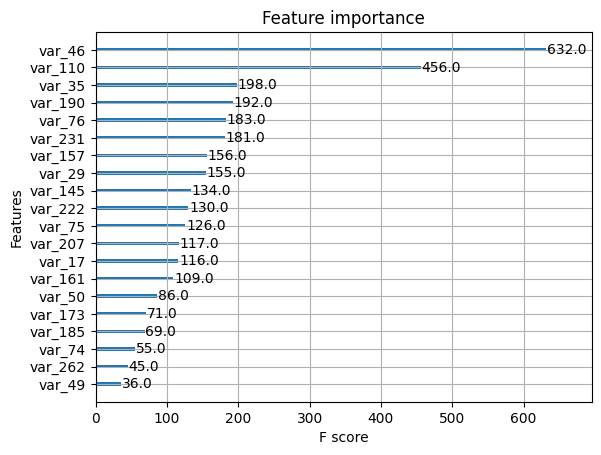

In [74]:
plot_importance(clf)
plt.show()

Możemy spojrzeć co się stanie jeśli usuniemy 2 kolumny o najmniejszym znaczeniu

In [75]:
clf.fit(X_train_rfe.drop(['var_49', 'var_262'], axis=1), y_train)

y_pred = clf.predict(X_test_rfe.drop(['var_49', 'var_262'], axis=1))
y_pred_probs = clf.predict_proba(X_test_rfe.drop(['var_49', 'var_262'], axis=1))[:, 1]

#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))


print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train_rfe.drop(['var_49', 'var_262'], axis=1), y_train, cv=5, scoring="roc_auc")
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="f1")
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.10      0.01      0.01       179

    accuracy                           0.96      4500
   macro avg       0.53      0.50      0.49      4500
weighted avg       0.93      0.96      0.94      4500

Wynik ROC-AUC na zbiorze testowym:  0.8229162761051328
Wynik ROC-AUC przez cross-validation:  [0.80898168 0.7715631  0.80239009 0.7975777  0.7810815 ]
Wynik F1 przez cross-validation:  [0.02076125 0.01369863 0.02061856 0.01384083 0.01365188]


Precision mocno spadł natomiast, F1 trochę poszedł do góry, a wynik ROC-AUC praktycznie nie uległ zmianie. Ponieważ my i tak mamy jedynie 20 kolumn nie potrzebne jest usuwać kolejne kosztem utraty wyników, jednak gdyby oznaczało to znaczne zwiększenie efyktywności modelu można by się nad tym zastanowić

#### Naive Bayes

In [28]:
clf = GaussianNB()

Base preprocessing

In [77]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_probs = clf.predict_proba(X_test)[:, 1]

#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))


print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)


              precision    recall  f1-score   support

           0       0.99      0.13      0.23      4321
           1       0.04      0.96      0.08       179

    accuracy                           0.16      4500
   macro avg       0.52      0.55      0.16      4500
weighted avg       0.95      0.16      0.22      4500

Wynik ROC-AUC na zbiorze testowym:  0.7408324164564637
Wynik ROC-AUC przez cross-validation:  0.7408062960736502
Wynik F1 przez cross-validation:  0.08366627473079377


Preprocessing RFE

In [81]:
clf.fit(X_train_rfe, y_train)

y_pred = clf.predict(X_test_rfe)
y_pred_probs = clf.predict_proba(X_test_rfe)[:, 1]

#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))

print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.99      0.24      0.39      4321
           1       0.05      0.92      0.09       179

    accuracy                           0.27      4500
   macro avg       0.52      0.58      0.24      4500
weighted avg       0.95      0.27      0.38      4500

Wynik ROC-AUC na zbiorze testowym:  0.7567000965791336
Wynik ROC-AUC przez cross-validation:  0.7443173831407464
Wynik F1 przez cross-validation:  0.08985748530680153


Zaczynamy zauważać trend że wyniki na ramce po preprocessing RFE są w każdym modelu lepsze od base preprocessingu. Model NB ma trochę ROC od XGboost ale za to zdecydowanie wyższy F1. Wydaje się to narazie najlepsze połączenie dobrego wyniku F1 i ROC.

Spróbujemy zatem poprzez hiperparametry znaleźć najlepszą wartość parametru var_smoothing w celu otrzymana najlepszego wyniku F1

In [49]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=clf, 
                     param_grid=params_NB, 
                     cv=5,
                     verbose=1, 
                     scoring='f1')


Data_transformed = PowerTransformer().fit_transform(X_train_rfe)
gs_NB.fit(Data_transformed, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5, estimator=GaussianNB(var_smoothing=0.23101297000831597),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='f1', verbose=1)

In [50]:
print(gs_NB.best_params_)
print(gs_NB.best_score_)

{'var_smoothing': 0.2848035868435802}
0.25180493348414446


In [51]:
clf = GaussianNB(**gs_NB.best_params_)
X_train_transformed = PowerTransformer().fit_transform(X_train_rfe)
X_test_transformed = PowerTransformer().fit_transform(X_test_rfe)

clf.fit(X_train_transformed, y_train)

y_pred = clf.predict(X_test_transformed)
y_pred_probs = clf.predict_proba(X_test_transformed)[:, 1]

#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))

print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train_transformed, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train_transformed, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.96      4500
   macro avg       0.48      0.50      0.49      4500
weighted avg       0.92      0.96      0.94      4500

Wynik ROC-AUC na zbiorze testowym:  0.7826154973954663
Wynik ROC-AUC przez cross-validation:  0.731134148056193
Wynik F1 przez cross-validation:  0.25180493348414446


#### Random Tree Forest

#### Hiperparametry

Do modelu random tree forest użujemy metody random search znajdowania hiperparametrów. Będziemy używać ramki X_train_rfe żeby znajdowanie nie trwało zbyt długo

Random Hyperparameter Grid


In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }
print(random_grid)


{'n_estimators': [100, 122, 144, 166, 188, 211, 233, 255, 277, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


1. Optymalizacja do ROC-AUC

In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, scoring = 'roc_auc', cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 122, 144, 166,
                                                         188, 211, 233, 255,
                                                         277, 300]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
0.8201015282237034


In [83]:
clf = RandomForestClassifier(n_estimators = 300, min_samples_split = 10, min_samples_leaf = 2, max_features = 'sqrt', max_depth = 10, bootstrap = True)
clf.fit(X_train_rfe, y_train)

y_pred = clf.predict(X_test_rfe)
y_pred_probs = clf.predict_proba(X_test_rfe)[:, 1]


#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))

print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4321
           1       0.00      0.00      0.00       179

    accuracy                           0.96      4500
   macro avg       0.48      0.50      0.49      4500
weighted avg       0.92      0.96      0.94      4500

Wynik ROC-AUC na zbiorze testowym:  0.8412624327857068
Wynik ROC-AUC przez cross-validation:  0.8196437722579393
Wynik F1 przez cross-validation:  0.0


Wynik ROC-AUC jest dosyć wysoki jednak niewiele wyższy niż w XGBoost a za to znowu wróciliśmy do przewidywania samych 0 na zbiorze testowym oraz F1 = 0

2. Optymalizacja do wyniku F1

In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, scoring = 'f1', cv = 5, verbose=2, random_state=42, n_jobs = -1, error_score='raise')
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=RandomForestClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 122, 144, 166,
                                                         188, 211, 233, 255,
                                                         277, 300]},
                   random_state=42, scoring='f1', verbose=2)

In [ ]:
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 122, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 98, 'bootstrap': False}
0.07327140362125067


In [84]:
clf = RandomForestClassifier( n_estimators = 122, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = 98, bootstrap = False)

clf.fit(X_train_rfe, y_train)

y_pred = clf.predict(X_test_rfe)
y_pred_probs = clf.predict_proba(X_test_rfe)[:, 1]


#Raport z wskaźnikami oceny modelu
print(classification_report(y_test, y_pred))

print("Wynik ROC-AUC na zbiorze testowym: ", roc_auc_score(y_test, y_pred_probs))

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="roc_auc").mean()
print("Wynik ROC-AUC przez cross-validation: ", scores)

scores = cross_val_score(clf, X_train_rfe, y_train, cv=5, scoring="f1").mean()
print("Wynik F1 przez cross-validation: ", scores)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4321
           1       0.17      0.04      0.06       179

    accuracy                           0.95      4500
   macro avg       0.57      0.52      0.52      4500
weighted avg       0.93      0.95      0.94      4500

Wynik ROC-AUC na zbiorze testowym:  0.7754800189796743
Wynik ROC-AUC przez cross-validation:  0.753144928880608
Wynik F1 przez cross-validation:  0.0698022819423614


Jak widzimy metoda znajdowania hiperparametrów nie dała wyników lepszych niż Naive Bayes.

### Naszym zdaniem najlepsze wyniki otrzymaliśmy z modelu Naive Bayes dla preprocessingu RFE